In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [12]:
#step1
def calculate_volatility(data, n):
    x1 = data[:n]
    x_1 = np.sqrt(np.sum(x1)/n)
    sigma1 = np.sqrt(np.sum(x1 - x_1) / n)

    x2 = data[-n:]
    x_2 = np.sqrt(np.sum(x2)/n)
    sigma2 = np.sqrt(np.sum((x2 - x_2)) / n)

    return sigma1, sigma2

def add_padding(data, sigma1, sigma2, m):
    square_sigma1=np.sqrt(sigma1)
    square_sigma2=np.sqrt(sigma2)
    
    padding_front = []
    for i in range(m):
        if i == 0:
            padding_front.append(data[0] + np.random.normal(0, square_sigma1))
        else:
            padding_front.append(padding_front[-1] + np.random.normal(0, square_sigma1))

    padding_back = []
    for i in range(m):
        if i == 0:
            padding_back.append(data[-1] + np.random.normal(0, square_sigma2))
        else:
            padding_back.append(padding_back[-1] + np.random.normal(0, square_sigma2))

    new_data = np.concatenate([padding_front[::-1], data, padding_back])
    return new_data

In [13]:
#step2:FFT将时域信号转换为频域信号，并返回频率、振幅以及原始FFT结果
def perform_fft(data, use_shift=True):
    fft_result = np.fft.fft(data)#进行快速傅里叶变换，得到频域结果fft_result
    frequencies = np.fft.fftfreq(len(data), d=1)#频率数组 frequencies，采样间隔为 1
    amplitude = np.abs(fft_result)#振幅，即fft_result 的绝对值
    if use_shift:
        frequencies = np.fft.fftshift(frequencies)#将频率和振幅数组重新排列，使零频成分居中。
        amplitude = np.fft.fftshift(amplitude)
    
    return {#返回一个字典，包含频率数组、振幅数组和原始 FFT 结果
        'frequencies': frequencies,
        'amplitude': amplitude,
        'fft_result': fft_result
    }

In [4]:
# step3: 根据给定阈值对频域信号进行滤波
def apply_threshold(fft_data, epsilon,use_shift=True):
    frequencies = fft_data['frequencies']
    fft_result = fft_data['fft_result']
    # 创建一个与fft_result相同形状的全零数组
    filtered_fft_result = np.zeros_like(fft_result,dtype=complex)

    for k in range(len(frequencies)):
        f_k = frequencies[k]
        if np.abs(f_k) > np.abs(epsilon):
            # 如果频率绝对值小于阈值绝对值，保留原始系数
            filtered_fft_result[k] = fft_result[k]
        else:
            # 否则将系数设为0
            filtered_fft_result[k] = 0

        filtered_amplitude = np.abs(np.fft.fftshift(filtered_fft_result)) if use_shift else np.abs(filtered_fft_result)
    return {
        'frequencies': frequencies,
        'amplitude': filtered_amplitude,
        'fft_result': filtered_fft_result
    }


In [5]:
#step4：逆FFT变换恢复时间域
def inverse_fft(fft_filtered_data):
    # 确保输入是字典，并提取 fft_result
    if isinstance(fft_filtered_data, dict):
        fft_filtered = fft_filtered_data['fft_result']
    else:
        fft_filtered = fft_filtered_data  # 如果直接传入数组，也兼容
    
    denoised_padded = np.fft.ifft(fft_filtered).real
    return denoised_padded

In [6]:
#step5：移除填充区域
def remove_padding(denoised_padded, original_length, m):
    start_idx = m
    end_idx = m + original_length
    denoised_data = denoised_padded[start_idx:end_idx]
    return denoised_data

In [ ]:
#step1可视化-折线图
def plot_data(data, title='Title', xlabel='Year', ylabel='Y-axis', label='Data'):
    plt.figure(figsize=(5, 4))
    plt.plot(data, color='blue', label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
#step2可视化-折线图2
def plot_padded_data(new_data, m, stock_data,dates):
    # 分离填充和原始数据
    padding_front = new_data[:m]
    original_data = new_data[m:m + len(stock_data)]
    padding_back = new_data[m + len(stock_data):]

    plt.figure(figsize=(5, 4))

    # 生成前端填充部分的虚拟日期
    front_dates = pd.date_range(start=dates[0] - pd.Timedelta(days=m), periods=m).year

    # 绘制前端填充数据
    plt.plot(front_dates, padding_front, color='red', label='Front Padding')

    # 绘制原始数据，确保与前端填充数据连接
    plt.plot(dates.year, stock_data, color='blue', label='Original Data')

    # 生成后端填充部分的虚拟日期
    back_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=m).year

    # 绘制后端填充数据，确保与原始数据连接
    plt.plot(back_dates, padding_back, color='red', label='Back Padding')

    # 设置标题和坐标轴标签
    plt.title('Stock Data with Padding')
    plt.xlabel('Year')
    plt.ylabel('Value')

    # 添加图例
    plt.legend()

    # 显示图形
    plt.show()

In [ ]:
# step3可视化-谱线图
def visualize_fft_results(fft_data, title="FFT Result", inset_range=None, figsize=(6, 4),ylim=None):

    # 从输入的数据里提取出频率值和对应的振幅值，准备用来画图
    frequencies, amplitude = fft_data['frequencies'], fft_data['amplitude']
    
    # 创建一个画布(fig)和主图区域(ax)，大小由figsize参数决定
    fig, ax = plt.subplots(figsize=figsize)

    # 在主图的右上角创建一个小图(axins)，大小是主图的35%宽和35%高
    axins = inset_axes(ax, width="35%", height="35%", loc='upper right')
    
    # 同时在主图和小图上绘制频率-振幅曲线(蓝色线条)
    # 并且都加上网格线，透明度设为0.3(半透明效果)
    for a in [ax, axins]:
        a.plot(frequencies, amplitude, 'b-')
        a.grid(True, alpha=0.3)
    
    # 设置主图属性
    # 给主图加上X轴标签(频率)、Y轴标签(振幅)和标题(由title参数决定)
    ax.set(xlabel='Frequency (Hz)', 
           ylabel='Amplitude', 
           title=title)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    
    # 设置小图属性
    if inset_range:
        # 如果指定了inset_range参数，就设置小图的X轴和Y轴显示范围
        # 同时给小图加上标题"High Frequency Details"(高频细节)
        axins.set(xlim=inset_range[:2], ylim=inset_range[2:], 
                  title='High Frequency Details')
        
        # 在主图和小图之间画一个指示框和连接线
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    # 自动调整子图的位置和大小
    plt.tight_layout()
    plt.show()


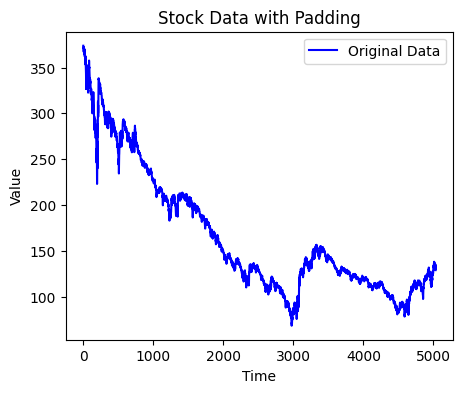

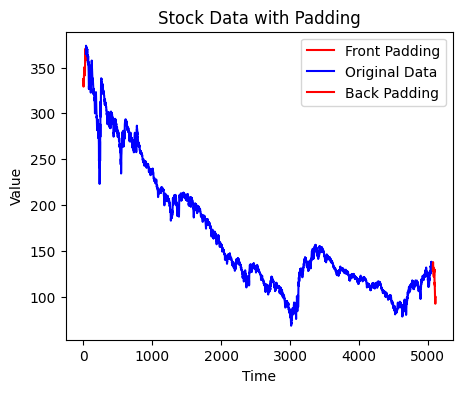

C:\Users\86137\AppData\Local\Temp\ipykernel_29028\2052987555.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


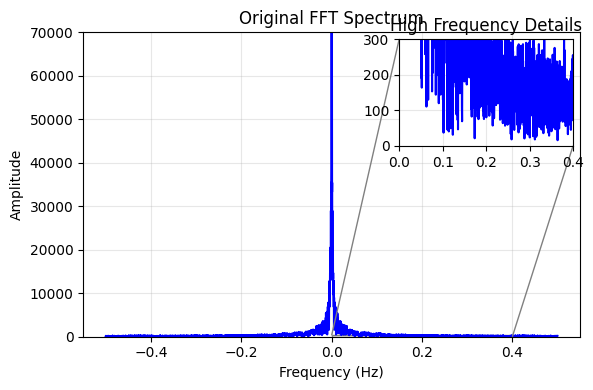

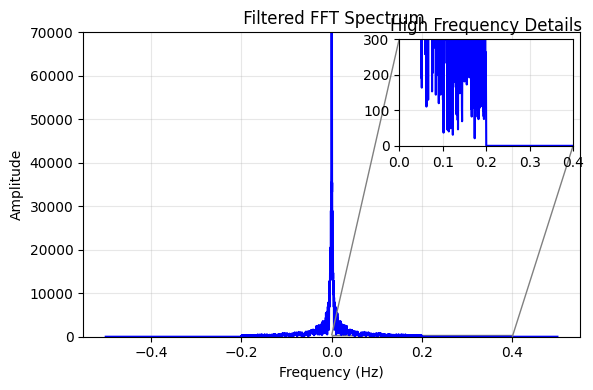

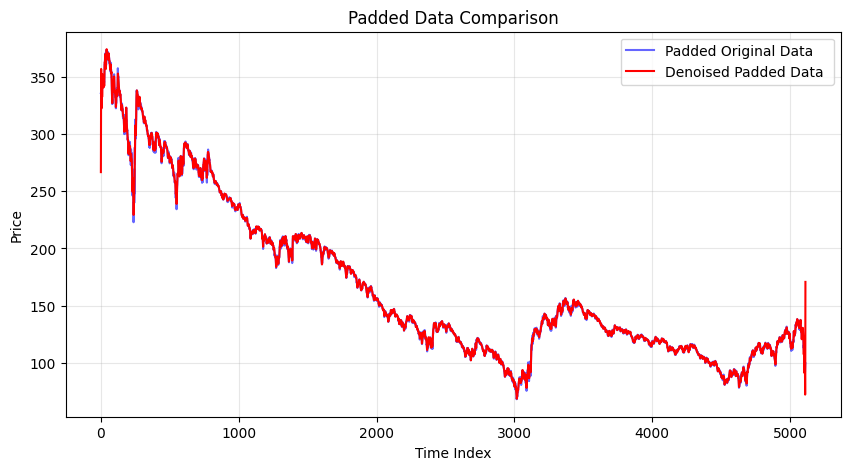

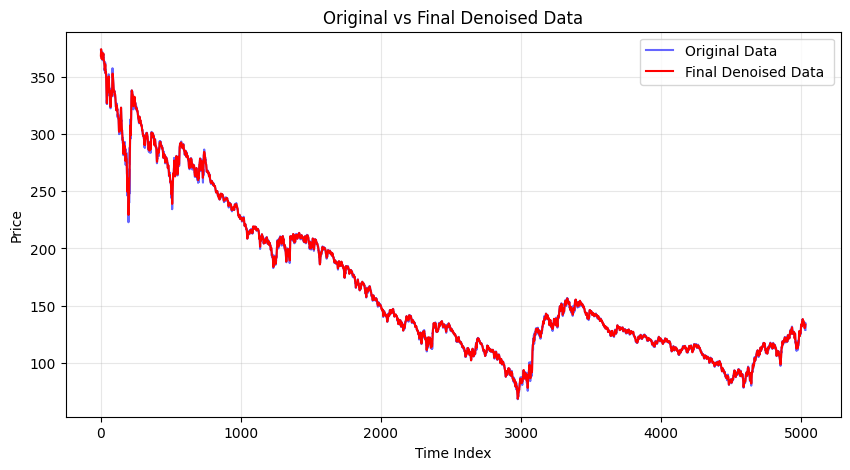

In [ ]:
# %%
# 完整流程复现（以AAPL数据为例）
file_path = 'SP500.csv'
stock_data = pd.read_csv(file_path)
dates = pd.to_datetime(stock_data['date'])  # 假设 CSV 文件中有 'date' 列
stock_data = stock_data['close'].values
N = len(stock_data)
m = 40  # 填充区域大小
n = 20  # 波动率计算窗口
epsilon = 0.3  # 频率阈值

# 步骤1：计算波动率并添加填充
sigma1, sigma2 = calculate_volatility(stock_data, n)
new_data = add_padding(stock_data, sigma1, sigma2, m)

# 步骤2：FFT变换
fft_data = perform_fft(new_data,use_shift=True)

# 步骤3：阈值处理
filtered_fft_data= apply_threshold(fft_data, epsilon,use_shift=True)
amplitude_filtered = filtered_fft_data['amplitude']

# 步骤4：逆FFT恢复时间域
denoised_padded = inverse_fft(filtered_fft_data)

# 步骤5：移除填充区域
denoised_data = remove_padding(denoised_padded, N, m)


# 可视化1原始数据
plot_data(stock_data, title='Stock Data with Padding', xlabel='Year', ylabel='Value', label='Original Data')

# 可视化2填充后的数据
plot_padded_data(new_data, m, stock_data,dates)


# 可视化3：FFT频谱
fft_data = perform_fft(new_data, use_shift=True) 
visualize_fft_results(
  fft_data,
  title="Original FFT Spectrum",
  inset_range=(0, 0.4, 0, 300) ,
  ylim=(0,70000)
)

#可视化4：过滤后的频谱
visualize_fft_results(
  filtered_fft_data ,
  title=" Filtered FFT Spectrum",
  inset_range=(0, 0.4, 0, 300),
  ylim=(0,70000)
)

# 可视化5：合并可视化2和可视化4：填充数据 vs 去噪数据（带填充）
plt.figure(figsize=(10, 5))
# 生成填充后数据的日期
all_dates = pd.concat([
    pd.date_range(start=dates[0] - pd.Timedelta(days=m), periods=m),
    dates,
    pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=m)
])

# 绘制填充后的原始数据（蓝色）
plt.plot(all_dates.year, new_data, 'b-', alpha=0.6, label='Padded Original Data')
# 绘制去噪后的填充数据（红色）
plt.plot(all_dates.year, denoised_padded, 'r-', label='Denoised Padded Data '.format(epsilon))
plt.title('Padded Data Comparison')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#可视化6：去掉之前的填充部分
plt.figure(figsize=(10, 5))
# 绘制原始数据（蓝色）
plt.plot(dates.year, stock_data, 'b-', alpha=0.6, label='Original Data')
# 绘制最终去噪数据（红色）
plt.plot(dates.year, denoised_data, 'r-', label='Final Denoised Data '.format(epsilon))
plt.title('Original vs Final Denoised Data')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
